# Chapter 3: DBSCAN

In [1]:
from sklearn.datasets import make_blobs
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np
import math
import sys
%matplotlib inline

# Set sig digits for output
np.set_printoptions(precision=3)

### DBSCAN Intuition by Example

Follow along below for a toy example of how DBSCAN works with a very simple use case. You will notice that many of the fields are hard-coded and this code shouldn't be interpreted as an ideal implementation.

[[ 1  7]
 [-8  6]
 [-9  4]
 [ 4 -2]]


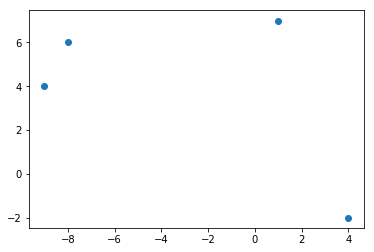

In [4]:
# Create 4 random test points
example = np.reshape([1,7,-8,6,-9,4,4,-2], (4,2))
print(example)
plt.scatter(example[:,0], example[:,1])
plt.show()

In [6]:
# Calculate Euclidean distance between data points
distances = cdist(example,example)

# Make diagonals infinity so np.argmin doesn't think the closest neighbor is itself
np.fill_diagonal(distances,sys.maxsize)

# View what the distance matrix looks like. 
# Infinity across diagonal, with distances mirrored across it ( you only need the bottom left )
print(distances)

[[9.223e+18 9.055e+00 1.044e+01 9.487e+00]
 [9.055e+00 9.223e+18 2.236e+00 1.442e+01]
 [1.044e+01 2.236e+00 9.223e+18 1.432e+01]
 [9.487e+00 1.442e+01 1.432e+01 9.223e+18]]


In [64]:
# For each point in your data set, evaluate which other points fall within a given neighborhood radius of 3

neighborhood_radius = 3

radius_check = np.argwhere(distances <= neighborhood_radius)

print(radius_check)

[[1 2]
 [2 1]]


As we can see from the above thresholding exercise, the point at index 1 has a neighbor of the point at index 2, and vice versa. This means they are candidates to be clustered together. Points that have no neighbors (points at indices 0 and 3) are marked as noise and remain un-clustered.

If points in your data set DO have neighbors based on the above cell's calculation, they need to be evaluated using the minimum points threshold. If they pass the threshold they can be clustered, otherwise they too will be marked as noise.

In [71]:
minimum_points = 2

if len(radius_check) == minimum_points:
    print("Points " + str(radius_check[0][0]) + " and " + str(radius_check[1][0]) + " will be clustered!")
else:
    print("Every data point is noise")

Points 1 and 2 will be clustered!


### Exercise 1: Evaluating Impact of Neighborhood Size

In [217]:
# Import helper functions from SciPy
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import DBSCAN

In [218]:
# Generate a random cluster dataset to experiment on. X = coordinate points, y = cluster labels (not needed)
X, y = make_blobs(n_samples=1000, centers=8, n_features=2, random_state=800)

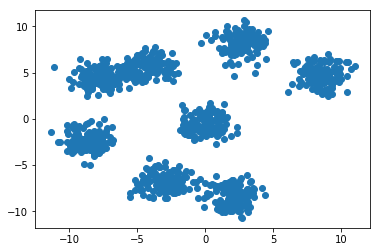

In [219]:
# Visualize the data
plt.scatter(X[:,0], X[:,1])
plt.show()

In [220]:
db = DBSCAN(eps=0.5, min_samples=10, metric='euclidean')

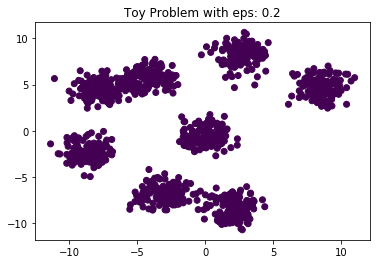

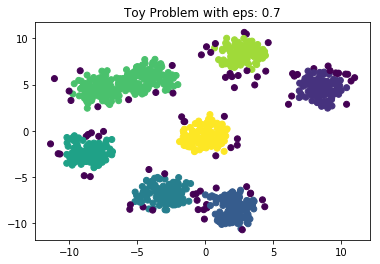

In [221]:
eps = [0.2,0.7]

for ep in eps:
    db = DBSCAN(eps=ep, min_samples=10, metric='euclidean')
    plt.scatter(X[:,0], X[:,1], c=db.fit_predict(X))
    plt.title('Toy Problem with eps: ' + str(ep))
    plt.show()

### Activity 1: Implement DBSCAN from Scratch 

<b>Scenario:</b> You are given a data set without prior background information and are requested to find the clusters that fit the data set best.

<b>Aim:</b> Given what you’ve learned about DBSCAN and distance metrics from prior lessons, build an implementation of DBSCAN from scratch in Python. You are free to use NumPy and SciPy to evaluate distances here.


In [222]:
X_blob, y_blob = make_blobs(n_samples=500, centers=4, n_features=2, random_state=800)

In [223]:
def scratch_DBSCAN(x, eps, min_pts):
    """
    param x (list of vectors): your dataset to be clustered
    param eps (float): neigborhood radius threshold
    param min_pts (int): minimum number of points threshold for a nieghborhood to be a cluster
    """
 
    # Build a label holder that is comprised of all 0s
    labels = [0]* x.shape[0]

    # Arbitrary starting "current cluster" ID    
    C = 0
    
    # For each point p in x...
    # ('p' is the index of the datapoint, rather than the datapoint itself.)
    for p in range(0, x.shape[0]):
    
        # Only unvisited points can be evaluated as neighborhood centers
        if not (labels[p] == 0):
            continue
        
        # Find all of p's neighbors.
        neighbors = neighborhood_search(x, p, eps)
        
        # If there are not enough neighbor points, then it is classified as noise (-1).
        # Otherwise we can use this point as a neighborhood cluster
        if len(neighbors) < min_pts:
            labels[p] = -1    
        else: 
            C += 1
            neighbor_cluster(x, labels, p, neighbors, C, eps, min_pts)
    
    return labels


def neighbor_cluster(x, labels, p, neighbors, C, eps, min_pts):

    # Assign the cluster label to original point
    labels[p] = C
    
    # Look at each neighbor of p (by index, not the points themselves) and evaluate
    i = 0
    while i < len(neighbors):    
        
        # Get the next point from the queue.        
        potential_neighbor_ix = neighbors[i]
       
        # If potential_neighbor_ix is noise from previous runs, we can assign it to current cluster
        if labels[potential_neighbor_ix] == -1:
            labels[potential_neighbor_ix] = C
        
        # Otherwise, if potential_neighbor_ix is unvisited, we can add it to current cluster
        elif labels[potential_neighbor_ix] == 0:
            labels[potential_neighbor_ix] = C
            
            # Further find neighbors of potential neighbor
            potential_neighbors_cluster = neighborhood_search(x, potential_neighbor_ix, eps)
            
            if len(potential_neighbors_cluster) >= min_pts:
                neighbors = neighbors + potential_neighbors_cluster      
        
        # Evaluate next neighbor
        i += 1        

def neighborhood_search(x, p, eps):
    neighbors = []
    
    # For each point in the dataset...
    for potential_neighbor in range(0, x.shape[0]):
        
        # If a nearby point falls below the neighborhood radius threshold, add to neighbors list
        if np.linalg.norm(x[p] - x[potential_neighbor]) < eps:
            neighbors.append(potential_neighbor)
            
    return neighbors

### Evaluate Performance

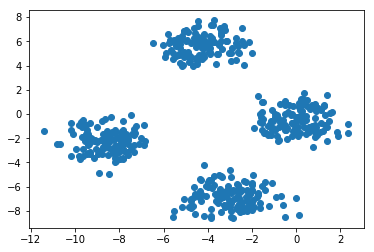

In [224]:
# Visualize the data
plt.scatter(X_blob[:,0], X_blob[:,1])
plt.show()

In [225]:
labels = scratch_DBSCAN(X_blob, 0.6, 5)

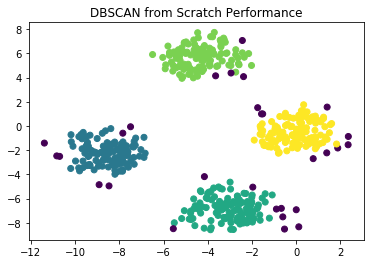

In [226]:
# Visualize the data
plt.scatter(X_blob[:,0], X_blob[:,1], c=labels)
plt.title("DBSCAN from Scratch Performance")
plt.show()

As you may have noticed it takes quite some time for a custom implementation to run. This is because we explored the non-vectorized version of this algorithm for the sake of clarity. Moving forward you should aim to use the DBSCAN implementation provided by Sci-Kit Learn as it is highly optimized.

### Exercise 2: Evaluating the Impact of Minimum Points Threshold

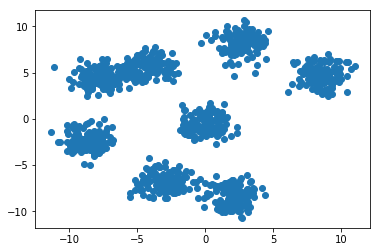

In [227]:
# Visualize the data
plt.scatter(X[:,0], X[:,1])
plt.show()

In [228]:
db = DBSCAN(eps=0.7, min_samples=10, metric='euclidean')

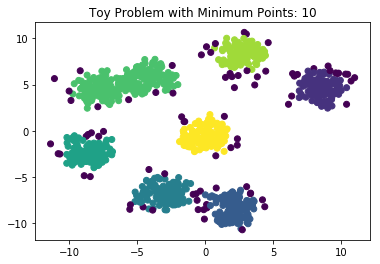

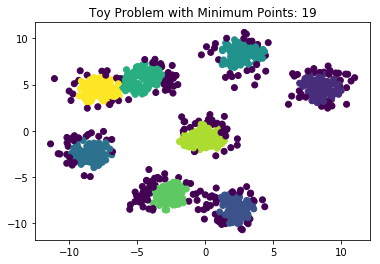

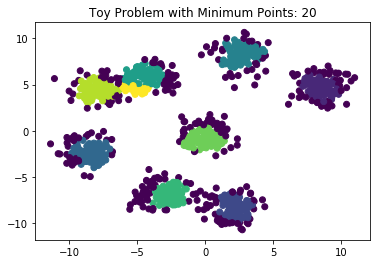

In [229]:
num_samples = [10,19,20]

for min_num in num_samples:
    db = DBSCAN(eps=0.7, min_samples=min_num, metric='euclidean')
    plt.scatter(X[:,0], X[:,1], c=db.fit_predict(X))
    plt.title('Toy Problem with Minimum Points: ' + str(min_num))
    plt.show()

### Activity 2: Compare DBSCAN with K-Means and Hierarchical Clustering

<b>Scenario: </b> Your manager is asking you to evaluate different clustering approaches to see which works best for your use case. You need to be able to report back on which clustering method is most relevant based off the data you have available.

<b>Aim: </b> Using Sci-Kit Learn implementations, evaluate how each of the clustering methods we’ve learned thus far perform on sample data you generate. You should explore blob-like data features as well as more complex data landscapes such as swiss-roll.


In [230]:
from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn.datasets import make_moons, make_circles, load_wine
from sklearn.metrics import accuracy_score

In [231]:
# Generate moon structures X and labels y (not needed)
X_moon, y_moon = make_moons(n_samples=1000, noise=.05, random_state=800)
X_circle, y_circle = make_circles(n_samples=1000, noise=.05, random_state=800, factor = 0.5)

# Wine data set 
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

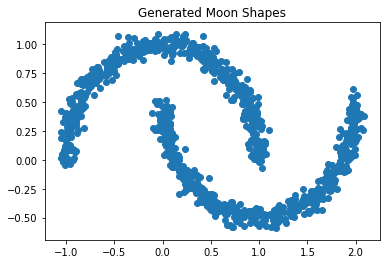

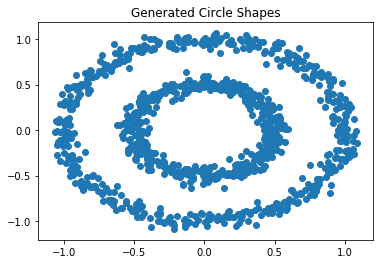

In [232]:
# Visualize the data
plt.scatter(X_moon[:,0], X_moon[:,1])
plt.title("Generated Moon Shapes")
plt.show()

# Visualize the data
plt.scatter(X_circle[:,0], X_circle[:,1])
plt.title("Generated Circle Shapes")
plt.show()

### Generated Moon Shape Data Set

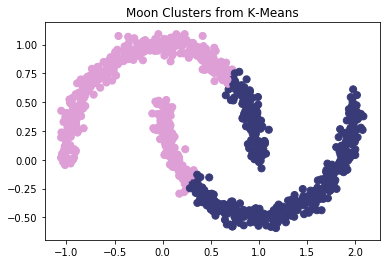

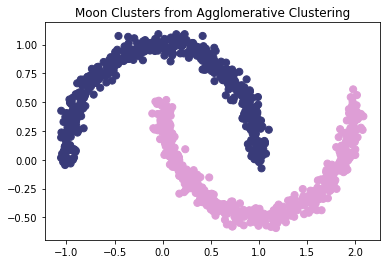

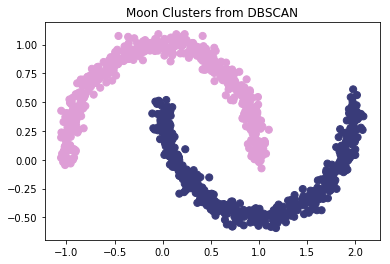

In [233]:
## Evaluate performance on generated Moon shape data

# Generate clusters from K-Means
km = KMeans(2)
km_clusters = km.fit_predict(X_moon)

# Generate clusters using Agglomerative Hierarchical Clustering
ac = AgglomerativeClustering(2, linkage='single')
ac_clusters = ac.fit_predict(X_moon)

# Generate clusters using DBSCAN
db = DBSCAN(eps=.2, min_samples=10)
db_clusters = db.fit_predict(X_moon)

plt.title("Moon Clusters from K-Means")
plt.scatter(X_moon[:,0], X_moon[:,1], c=km_clusters,s=50, cmap='tab20b')
plt.show()

plt.title("Moon Clusters from Agglomerative Clustering")
plt.scatter(X_moon[:,0], X_moon[:,1], c=ac_clusters,s=50, cmap='tab20b')
plt.show()

plt.title("Moon Clusters from DBSCAN")
plt.scatter(X_moon[:,0], X_moon[:,1], c=db_clusters,s=50, cmap='tab20b')
plt.show()

### Generated Circle Shape Data Set

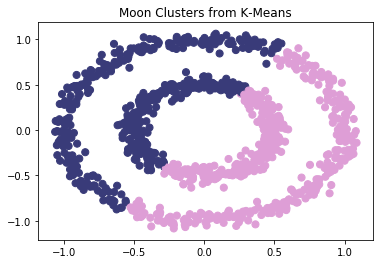

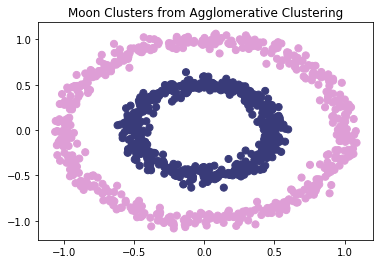

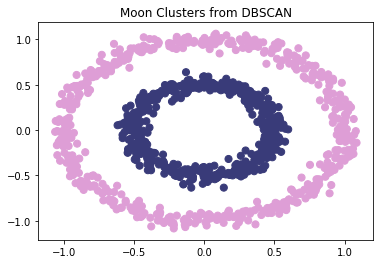

In [234]:
# Evaluate performance on generated Circle data

# Generate clusters from K-Means
km = KMeans(2)
km_clusters = km.fit_predict(X_circle)

# Generate clusters using Agglomerative Hierarchical Clustering
ac = AgglomerativeClustering(2, linkage='single')
ac_clusters = ac.fit_predict(X_circle)

# Generate clusters using DBSCAN
db = DBSCAN(eps=.2, min_samples=10)
db_clusters = db.fit_predict(X_circle)

plt.title("Moon Clusters from K-Means")
plt.scatter(X_circle[:,0], X_circle[:,1], c=km_clusters,s=50, cmap='tab20b')
plt.show()

plt.title("Moon Clusters from Agglomerative Clustering")
plt.scatter(X_circle[:,0], X_circle[:,1], c=ac_clusters,s=50, cmap='tab20b')
plt.show()

plt.title("Moon Clusters from DBSCAN")
plt.scatter(X_circle[:,0], X_circle[:,1], c=db_clusters,s=50, cmap='tab20b')
plt.show()

### Wine Data Set

Since the wine data set contains more features than we can visualize, we are only able to evaluate clustering performance by accuracy metrics instead of plotting.

In [235]:
# Generate clusters from K-Means
km = KMeans(3)
km_clusters = km.fit_predict(X_wine)

# Generate clusters using Agglomerative Hierarchical Clustering
ac = AgglomerativeClustering(3, linkage='complete')
ac_clusters = ac.fit_predict(X_wine)

# Generate clusters using DBSCAN
db = DBSCAN(eps=50, min_samples=10)
db_clusters = db.fit_predict(X_wine)

print("Clustering Performance on Wine Dataset\n")

print("K-Means Accuracy: " + str(accuracy_score(y_wine, km_clusters)))
print("Agglomerative Clusterig Accuracy: " + str(accuracy_score(y_wine, ac_clusters)))
print("DBSCAN Accuracy: " + str(accuracy_score(y_wine, db_clusters)))

Clustering Performance on Wine Dataset

K-Means Accuracy: 0.16853932584269662
Agglomerative Clusterig Accuracy: 0.6741573033707865
DBSCAN Accuracy: 0.5112359550561798


Notice that more advanced clustering algorithms such as DBSCAN are not perfect. Most of the time it is learning to find the right clustering approach for the data set you are working on at the time. K-Means typically only works on easily differentiable data sets. In the case of our Wine data set, Agglomerative Clustering outperforms DBSCAN by a decent margin (67% accuracy vs 51% accuracy). Notice that the supplied hyperparameters do a decent job but are far from perfect. Can you improve how well these clustering methods do?